# OCC

## MySQL에서 데이터 로드 

In [1]:
#pip install pymysql

In [6]:
#pip install seaborn

In [4]:
# import sys
# !{sys.executable} -m pip install lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.6.0-py3-none-linux_x86_64.whl size=2782344 sha256=603597694def882abfea96b6d1df7cac11d1943d6a6e3188892c0b0a582b1812
  Stored in directory: /home/lab08/.cache/pip/wheels/d4/3c/31/2928576362d765810777fb122626b8466a5a52abb3ead08bed
Successfully built lightgbm


In [1]:
import pymysql
import lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import config 
from config import DB_CONFIG
import pymysql  

# MySQL 연결
conn = pymysql.connect(
    host=DB_CONFIG['host'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    database=DB_CONFIG['database'],
    port=DB_CONFIG['port']
)

car_siren = f"SELECT * FROM merge50_car_siren"
car_horn = f"SELECT * FROM merge50_car_horn"
car_driving = f'SELECT * FROM merge50_car_driving'
motorcycle_horn  = f'SELECT * FROM merge50_motorcycle_horn'
motorcycle_driving  = f'SELECT * FROM merge50_motorcycle_driving'

car_siren_df =  pd.read_sql(car_siren, conn)
car_horn_df = pd.read_sql(car_horn, conn) 
car_driving_df = pd.read_sql(car_driving, conn) 
motorcycle_horn_df= pd.read_sql(motorcycle_horn, conn) 
motorcycle_driving_df = pd.read_sql(motorcycle_driving, conn) 

conn.close()

/tmp/ipykernel_23832/1259335500.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_siren_df =  pd.read_sql(car_siren, conn)
/tmp/ipykernel_23832/1259335500.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_horn_df = pd.read_sql(car_horn, conn)
/tmp/ipykernel_23832/1259335500.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_driving_df = pd.read_sql(car_driving, conn)
/tmp/ipykernel_23832/1259335500.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI 

# EDA 및 전처리

In [3]:
print(f'car_siren 데이터 개수: {car_siren_df.shape[0]}')
print(f'car_horn 데이터 개수: {car_horn_df.shape[0]}')
print(f'car_driving 데이터 개수: {car_driving_df.shape[0]}')
print(f'motorcycle_horn 데이터 개수: {motorcycle_horn_df.shape[0]}')
print(f'motorcycle_driving 데이터 개수: {motorcycle_driving_df.shape[0]}')

car_siren 데이터 개수: 1990
car_horn 데이터 개수: 3189
car_driving 데이터 개수: 1682
motorcycle_horn 데이터 개수: 4560
motorcycle_driving 데이터 개수: 4735


In [11]:
car_horn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fileName       3189 non-null   object 
 1   labelName      3189 non-null   object 
 2   area_start     3189 non-null   float64
 3   area_end       3189 non-null   float64
 4   category_01    3189 non-null   object 
 5   category_02    3189 non-null   object 
 6   category_03    3189 non-null   object 
 7   decibel        3189 non-null   int64  
 8   soundQuality   3189 non-null   object 
 9   subCategory    3189 non-null   object 
 10  bitRate        3189 non-null   object 
 11  duration       3189 non-null   float64
 12  fileFormat     3189 non-null   object 
 13  fileSize       3189 non-null   int64  
 14  recodingType   3189 non-null   object 
 15  sampleRate     3189 non-null   object 
 16  acqDevice      3189 non-null   object 
 17  acqMethod      3189 non-null   object 
 18  acqType 

In [12]:
car_horn_df.head()

,fileName,labelName,area_start,area_end,category_01,category_02,category_03,decibel,soundQuality,subCategory,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,1.car_horn_30849_1.wav,1.car_horn_30849_1.wav,2.0,11.048,교통소음,자동차,차량경적,68,정상,소형차경적,...,37.183453,-10.836115,25.585962,0.232516,5.053774,12.176615,4.831705,-8.831820,10.174751,2.365335
1,1.car_horn_30865_1.wav,1.car_horn_30865_1.wav,2.0,10.672,교통소음,자동차,차량경적,75,정상,소형차경적,...,10.472818,-25.531940,-0.819976,-21.547447,16.138535,-0.490012,0.726548,-9.243734,-1.005557,-10.407813
2,1.car_horn_30869_1.wav,1.car_horn_30869_1.wav,2.0,12.245,교통소음,자동차,차량경적,68,정상,소형차경적,...,-2.516794,-12.093688,21.846487,10.806868,14.971516,9.503950,15.538783,15.781241,0.750223,-8.508451
3,1.car_horn_30874_1.wav,1.car_horn_30874_1.wav,2.0,10.289,교통소음,자동차,차량경적,69,정상,소형차경적,...,18.060278,-17.298338,28.503597,14.064431,7.452422,12.441176,16.612614,2.910048,-6.256705,-6.246398
4,1.car_horn_59_1.wav,1.car_horn_59_1.wav,2.0,4.029,교통소음,자동차,차량경적,107,정상,소형차경적,...,21.661055,-9.801945,12.513287,2.843365,8.194932,7.828580,8.889499,5.067267,2.928293,10.400720


In [13]:
car_horn_df.iloc[ : ,-13:] 

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-328.99643,110.927765,13.474552,37.183453,-10.836115,25.585962,0.232516,5.053774,12.176615,4.831705,-8.831820,10.174751,2.365335
1,-380.94937,82.016785,-38.369390,10.472818,-25.531940,-0.819976,-21.547447,16.138535,-0.490012,0.726548,-9.243734,-1.005557,-10.407813
2,-498.20813,114.061424,1.980113,-2.516794,-12.093688,21.846487,10.806868,14.971516,9.503950,15.538783,15.781241,0.750223,-8.508451
3,-456.39767,111.490440,-6.244432,18.060278,-17.298338,28.503597,14.064431,7.452422,12.441176,16.612614,2.910048,-6.256705,-6.246398
4,-199.50888,199.641110,-13.681638,21.661055,-9.801945,12.513287,2.843365,8.194932,7.828580,8.889499,5.067267,2.928293,10.400720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,-264.83923,197.210750,-77.277880,23.032236,11.380154,7.896886,11.269576,-4.560492,17.224950,4.160231,-1.057662,0.926013,-7.930759
3185,-426.90427,130.722400,47.745327,8.306962,5.675391,15.449170,5.677291,6.208929,-0.195498,-5.397255,-2.674880,-6.652485,-10.272819
3186,-316.11063,194.271060,-29.530697,35.808052,12.489090,23.182838,11.050718,3.705868,11.450807,-0.165664,2.353512,0.390641,5.358946
3187,-228.09323,64.343980,-13.663012,41.246460,-7.827433,21.293640,-13.415158,3.358162,5.326135,-3.165687,-11.261456,-1.512664,6.411310


In [14]:
#데이터프레임 병합 
df_combined = pd.concat([car_horn_df, car_siren_df,car_driving_df,motorcycle_horn_df,motorcycle_driving_df], ignore_index=True)

print(f'df_combined 행 개수: {len(df_combined)}') 
df_combined.head()

df_combined 행 개수: 16156


,fileName,labelName,area_start,area_end,category_01,category_02,category_03,decibel,soundQuality,subCategory,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,1.car_horn_30849_1.wav,1.car_horn_30849_1.wav,2.0,11.048,교통소음,자동차,차량경적,68,정상,소형차경적,...,37.183453,-10.836115,25.585962,0.232516,5.053774,12.176615,4.831705,-8.831820,10.174751,2.365335
1,1.car_horn_30865_1.wav,1.car_horn_30865_1.wav,2.0,10.672,교통소음,자동차,차량경적,75,정상,소형차경적,...,10.472818,-25.531940,-0.819976,-21.547447,16.138535,-0.490012,0.726548,-9.243734,-1.005557,-10.407813
2,1.car_horn_30869_1.wav,1.car_horn_30869_1.wav,2.0,12.245,교통소음,자동차,차량경적,68,정상,소형차경적,...,-2.516794,-12.093688,21.846487,10.806868,14.971516,9.503950,15.538783,15.781241,0.750223,-8.508451
3,1.car_horn_30874_1.wav,1.car_horn_30874_1.wav,2.0,10.289,교통소음,자동차,차량경적,69,정상,소형차경적,...,18.060278,-17.298338,28.503597,14.064431,7.452422,12.441176,16.612614,2.910048,-6.256705,-6.246398
4,1.car_horn_59_1.wav,1.car_horn_59_1.wav,2.0,4.029,교통소음,자동차,차량경적,107,정상,소형차경적,...,21.661055,-9.801945,12.513287,2.843365,8.194932,7.828580,8.889499,5.067267,2.928293,10.400720


In [15]:
df_combined.iloc[ : ,-13:] 

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-328.99643,110.927765,13.474552,37.183453,-10.836115,25.585962,0.232516,5.053774,12.176615,4.831705,-8.831820,10.174751,2.365335
1,-380.94937,82.016785,-38.369390,10.472818,-25.531940,-0.819976,-21.547447,16.138535,-0.490012,0.726548,-9.243734,-1.005557,-10.407813
2,-498.20813,114.061424,1.980113,-2.516794,-12.093688,21.846487,10.806868,14.971516,9.503950,15.538783,15.781241,0.750223,-8.508451
3,-456.39767,111.490440,-6.244432,18.060278,-17.298338,28.503597,14.064431,7.452422,12.441176,16.612614,2.910048,-6.256705,-6.246398
4,-199.50888,199.641110,-13.681638,21.661055,-9.801945,12.513287,2.843365,8.194932,7.828580,8.889499,5.067267,2.928293,10.400720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16151,-216.76335,227.552900,-82.289760,16.343384,-4.159147,-1.904160,10.840672,-6.094479,17.134110,-8.040121,-5.996139,-3.300848,-16.263510
16152,-260.36172,232.860840,-65.116700,39.084170,-3.065447,-7.736792,3.819775,-23.061602,6.557758,-13.926962,0.232121,0.180463,-9.043220
16153,-226.24818,233.032470,-56.155680,20.904785,-7.488766,-5.550318,1.841214,-16.429771,5.814109,-12.387865,-7.400935,-5.786819,-12.857692
16154,-200.10258,227.743970,-65.901590,5.604812,-13.910416,-17.113100,-6.478857,-20.236270,-2.118787,-16.228954,-6.787997,-3.972823,-13.148409


In [16]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # warning 메시지 숨기기

import tensorflow as tf
print("Is GPU available:", tf.test.is_gpu_available())

import tensorflow as tf
print('tf.__version__:',tf.__version__)

2025-02-26 16:47:50.729451: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 16:47:51.438866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 16:47:53.240102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
tf.__version__: 2.13.0


2025-02-26 16:47:55.698010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-26 16:47:55.800913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-26 16:47:55.802514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
tf.config.set_visible_devices([], 'GPU')

2025-02-26 16:47:57.757299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-26 16:47:57.758801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-26 16:47:57.760249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
!nvidia-smi

Wed Feb 26 16:47:57 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    25W /  70W |    845MiB / 15360MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 모델링

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 레이블(label)과 피처(features) 분리
X = df_combined.iloc[:, -13:]  # 마지막 13개 컬럼을 특성(MFCC)으로 사용
y = df_combined['category_03'].astype('category').cat.codes  # 범주형 데이터를 숫자로 변환

# 범주형 데이터(레이블) 숫자로 변환
y = y.astype('category').cat.codes

# 클래스 레이블 매핑
class_labels = df_combined['category_03'].astype('category').cat.categories

# 데이터셋 분할 (train: 80%, test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = len(set(y))

# LightGBM 모델 정의 및 학습
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 평가 결과 출력
acc = accuracy_score(y_test, y_pred)
print(f"LightGBM 정확도: {acc:.4f}")

# 혼동 행렬 및 분류 보고서 출력
print("\nConfusion Matrix:")
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_labels, columns=class_labels)
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels.tolist()))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 12924, number of used features: 13
[LightGBM] [Info] Start training from score -1.275101
[LightGBM] [Info] Start training from score -1.218836
[LightGBM] [Info] Start training from score -1.615959
[LightGBM] [Info] Start training from score -2.109285
[LightGBM] [Info] Start training from score -2.253810
LightGBM 정확도: 0.9208

Confusion Matrix:
        이륜차경적  이륜차주행음  차량경적  차량사이렌  차량주행음
이륜차경적     892       5    52      0      0
이륜차주행음      3     859    16      3     34
차량경적       26      25   553      5     12
차량사이렌       0       4     7    408      3
차량주행음       0      51    10      0    264

Classification Report:
              precision    recall  f1-score   support

      

In [21]:
import lightgbm as lgb

# 모델 저장 (LGBMClassifier는 내부적으로 Booster 객체를 포함)
model.booster_.save_model('lightgbm_eb.txt')
print("LightGBM 모델이 성공적으로 저장되었습니다!")

LightGBM 모델이 성공적으로 저장되었습니다!


In [28]:
# 모델 불러오기
lgb_model = lgb.Booster(model_file='lightgbm_eb.txt')
print("LightGBM 모델이 성공적으로 로드되었습니다!")


LightGBM 모델이 성공적으로 로드되었습니다!


In [29]:
lgb_model

In [57]:
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

num_classes = len(set(y))

# 모델 정의
model = Sequential()

# 첫 번째 convolutional layer
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# 두 번째 convolutional layer
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))


# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습 시작 시간 기록
start_time = time.time()

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test))

# 학습 종료 시간 기록
end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"총 학습 시간: {total_minutes:.2f}분")


Epoch 1/50
12924/12924 [==============================] - 53s 4ms/step - loss: 0.7260 - accuracy: 0.7426 - val_loss: 0.6131 - val_accuracy: 0.7624
Epoch 2/50
12924/12924 [==============================] - 63s 5ms/step - loss: 0.5300 - accuracy: 0.7951 - val_loss: 0.4976 - val_accuracy: 0.8103
Epoch 3/50
12924/12924 [==============================] - 34s 3ms/step - loss: 0.5023 - accuracy: 0.8107 - val_loss: 0.5016 - val_accuracy: 0.8075
Epoch 4/50
12924/12924 [==============================] - 32s 2ms/step - loss: 0.4746 - accuracy: 0.8218 - val_loss: 0.5080 - val_accuracy: 0.8150
Epoch 5/50
12924/12924 [==============================] - 32s 2ms/step - loss: 0.4625 - accuracy: 0.8305 - val_loss: 0.4208 - val_accuracy: 0.8379
Epoch 6/50
12924/12924 [==============================] - 40s 3ms/step - loss: 0.4473 - accuracy: 0.8366 - val_loss: 0.4805 - val_accuracy: 0.8159
Epoch 7/50
12924/12924 [==============================] - 66s 5ms/step - loss: 0.4476 - accuracy: 0.8356 - val_loss: 0

In [26]:
import os
import json
import librosa
import numpy as np
import pandas as pd

data_dir = "/home/ubuntu/data/etc_noise_data_test"

# 기존 데이터프레임이 존재하는지 확인
try:
    df_combined
except NameError:
    df_combined = pd.DataFrame()  # 없으면 빈 데이터프레임 생성

json_data = []
for file in os.listdir(data_dir):
    if file.endswith(".json"):
        with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
            data = json.load(f)

            annotations = data.get("annotations", [])
            annotation = annotations[0] if annotations and isinstance(annotations, list) else {}

            # JSON 파일명에서 확장자 제거
            base_name = os.path.splitext(file)[0]

            json_data.append({
                "baseName": base_name,  # 확장자 없는 파일명 저장
                "fileName": data["audio"]["fileName"],
                "labelName": annotation.get("labelName", None),
                "area_start": annotation.get("area", {}).get("start", None),
                "area_end": annotation.get("area", {}).get("end", None),
                "category_01": annotation.get("categories", {}).get("category_01", None),
                "category_02": annotation.get("categories", {}).get("category_02", None),
                "category_03": annotation.get("categories", {}).get("category_03", None),
                "decibel": annotation.get("decibel", None),
                "soundQuality": annotation.get("soundQuality", None),
                "subCategory": annotation.get("subCategory", None),
            })

df_json = pd.DataFrame(json_data)

# WAV 파일에서 MFCC 추출하는 함수
def extract_mfcc(file_path, sr=22050, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs, axis=1)  # MFCC 평균값 반환
    except Exception as e:
        print(f"오류 발생: {file_path} - {e}")
        return [None] * n_mfcc  # 오류 발생 시 None 리스트 반환

wav_data = []
for file in os.listdir(data_dir):
    if file.endswith(".wav"):
        file_path = os.path.join(data_dir, file)
        base_name = "_".join(file.split("_")[:-1])  # "_1.wav" 부분 제거하고 기본 파일명 추출
        mfcc_features = extract_mfcc(file_path)

        wav_data.append({
            "baseName": base_name,  # JSON과 매칭할 기본 파일명 저장
            **{f"mfcc_{i+1}": mfcc for i, mfcc in enumerate(mfcc_features)}
        })

df_wav = pd.DataFrame(wav_data)

# # JSON 데이터와 WAV 데이터 병합 (baseName 기준)
df_etc = pd.merge(df_json, df_wav, on="baseName", how="left").drop(columns=["baseName"])

# # 기존 데이터프레임 df_combined에 추가
# df_combined = pd.concat([df_combined, df_new], ignore_index=True)

# # 결과 확인
# print(df_combined.head())

In [37]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import time

# 📌 5️⃣ 기타 소음 데이터 로드 & 전처리 (OOD 탐지용)

# OOD 데이터 (기타 소음)
ood_X_test =  df_etc.iloc[ : ,-13:] 
ood_X_test = ood_X_test.values.reshape((ood_X_test.shape[0], ood_X_test.shape[1], 1)) # NumPy 배열로 변환 후 reshape (CNN 입력 형식 맞추기)


# 📌 6️⃣ Softmax 기반 OOD 탐지 함수
def predict_with_ood_detection(model, X, threshold=0.5):
    probs = model.predict(X)  # 확률 예측
    max_probs = np.max(probs, axis=1)  # 가장 높은 확률 값
    predictions = np.where(max_probs < threshold, num_classes, np.argmax(probs, axis=1))  
    return predictions  # threshold보다 낮으면 OOD(기타 소음)으로 분류

# 📌 7️⃣ OOD 탐지 적용 (테스트 데이터 & 기타 소음 데이터)
y_pred_test = predict_with_ood_detection(model, X_test, threshold=0.5)
y_pred_ood = predict_with_ood_detection(model, ood_X_test, threshold=0.5)

# 📌 8️⃣ 결과 출력
print("✅ 테스트 데이터 예측 결과:", y_pred_test)
print("✅ OOD (기타 소음) 예측 결과:", y_pred_ood)  # 대부분 '기타 소음'으로 분류되어야 함!

1/1 [==============================] - 0s 101ms/step
✅ 테스트 데이터 예측 결과: [2 4 5 ... 4 0 3]
✅ OOD (기타 소음) 예측 결과: [1 1 1 2 1 2 1 2 1 1 1 1 4 2 2 1 1 4 4 1]


In [67]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 📌 5️⃣ 기타 소음 데이터 로드 & 전처리 (OOD 탐지용)
ood_X_test = df_etc.iloc[:, -13:]  # 마지막 13개 MFCC 특징만 선택
ood_X_test = ood_X_test.values.reshape((ood_X_test.shape[0], ood_X_test.shape[1], 1))  # CNN 입력 형식 맞추기

# 📌 6️⃣ Softmax 기반 OOD 탐지 함수
def predict_with_ood_detection(model, X, threshold=0.6):
    probs = model.predict(X)  # Softmax 확률 출력
    max_probs = np.max(probs, axis=1)  # 가장 높은 확률 값 가져오기
    preds = np.argmax(probs, axis=1)  # 가장 높은 확률의 클래스 가져오기
    
    # 확률이 낮은 경우 "기타 소음"(-1)으로 변경
    final_preds = np.where(max_probs < threshold, -1, preds)  
    
    return final_preds

# 📌 7️⃣ OOD 탐지 적용 (테스트 데이터 & 기타 소음 데이터)
y_pred_test = predict_with_ood_detection(model, X_test, threshold=0.8)
y_pred_ood = predict_with_ood_detection(model, ood_X_test, threshold=0.8)

# 📌 8️⃣ 결과 출력
print("✅ 테스트 데이터 예측 결과:", y_pred_test)
print("✅ OOD (기타 소음) 예측 결과 (Softmax 기반 필터링):", y_pred_ood)


1/1 [==============================] - 0s 19ms/step
✅ 테스트 데이터 예측 결과: [ 2 -1 -1 ... -1  0  3]
✅ OOD (기타 소음) 예측 결과 (Softmax 기반 필터링): [ 2  1 -1  1  1 -1  1  1  1  1  1  1 -1  1  4 -1  1 -1  4 -1]


In [54]:
from tensorflow.keras.models import load_model

model_uncertain = load_model('/home/lab08/git/noise-data-platform/ES/model_uncertain_0.h5')
print("모델이 성공적으로 로드되었습니다!")

모델이 성공적으로 로드되었습니다!


## 훈련 정확도와 검증 정확도 비교

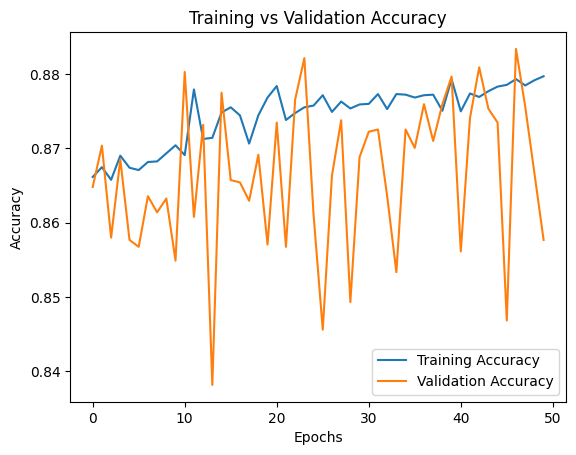

In [53]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 데이터 정확도: {test_acc:.4f}")


101/101 [==============================] - 0s 1ms/step - loss: 0.4445 - accuracy: 0.8577
테스트 데이터 정확도: 0.8577


## 혼동행렬

101/101 [==============================] - 0s 1ms/step


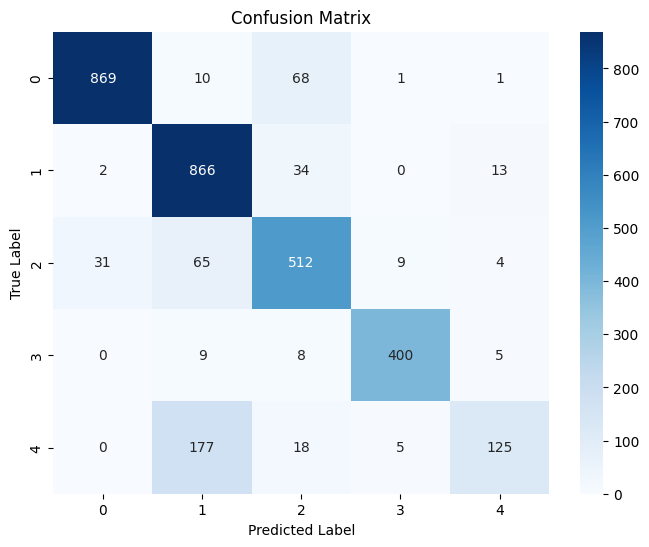

In [59]:
# 예측값 생성
y_pred = np.argmax(model.predict(X_test), axis=1)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## precision, recall, f1-score

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       949
           1       0.77      0.95      0.85       915
           2       0.80      0.82      0.81       621
           3       0.96      0.95      0.96       422
           4       0.84      0.38      0.53       325

    accuracy                           0.86      3232
   macro avg       0.87      0.80      0.82      3232
weighted avg       0.86      0.86      0.85      3232



In [134]:
import random

X_test = X_test.reset_index(drop=True)

# 테스트 데이터에서 샘플 선택
index = random.randint(0, len(X_test) - 1)
sample = X_test.iloc[index].values.reshape(1, X_test.shape[1], 1)  # CNN 입력 형태로 변환
# 예측 수행
prediction = model.predict(sample)
predicted_label = np.argmax(prediction)

print(f"실제 라벨: {y_test.iloc[index]}")

print(f"예측된 라벨: {predicted_label}")

1/1 [==============================] - 0s 17ms/step
실제 라벨: 3
예측된 라벨: 3
